# <center> Прототип решения по Треку 3:</center> <center> «Предсказание вероятности возникновения ДТП»</center>

## Постановка задачи

Разработать алгоритм прогнозирующий наиболее вероятную категорию события дорожно-транспортного происшествия (далее по тексту «ДТП»):

>1. ДТП не произойдет
>1. ДТП произойдет без пострадавших
>1. ДТП произойдет с пострадавшими

Данные для обучения — информация о ДТП от ГИБДД и ВНИИ ГОЧС, а также дополнительные данные по интенсивности движения, метеоусловиях на участках дороги и др. В качестве федеральных автомобильных дорог рассматриваются М-8 «Холмогоры» и Р-21 «Кола».

## Прототип решения

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import re
import functools
from geopy.distance import geodesic
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np

In [2]:
!pip install geopy

In [4]:
!pip install -U scikit-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.0
    Uninstalling scikit-learn-0.23.0:
      Successfully uninstalled scikit-learn-0.23.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'd:\\programs\\anaconda\\lib\\site-packages\\~-learn\\.libs\\vcomp140.dll'
Consider using the `--user` option or check the permissions.



In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### 1. Подготовка датасета для обучения модели

In [3]:
df = pd.read_csv('train.csv', usecols=[0, 1, 2, 10], parse_dates=['datetime'])
df = df.sort_values('datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
df.head(5)

,datetime,road_id,road_km,target
0,2012-01-01 12:00:00,14,1276,2
1,2012-01-01 22:00:00,9,278,2
2,2012-01-01 23:00:00,5,72,2
3,2012-01-02 07:00:00,5,1177,2
4,2012-01-02 08:00:00,5,1344,2


In [4]:
df.shape

(112317, 4)

#### Тренеровочный датасет (`train.csv`):
> 1. **datetime** - дата события в формате `yyyy-MM-dd hh-mm-ss`
> 1. **road_id** - код автодороги, принимает одно из трех значений:
>    * 5 — М-4 (E115) “Дон” Москва - Новороссийск;
>    * 9 — М-8 (E115) “Холмогоры” Москва - Архангельск через Ярославль, Вологду;
>    * 4 — М-18 / Р-21 (E105) “Кола” С.Петербург - Мурманск через Петрозаводск.
> 1. **road_km** - км участка на котором произошло ДТП
> 1. **data_source** - источник данных события. В датасете атрибут принимает одно из двух значений:
>    * gibdd - ГИБДД;
>    * gochs - МЧС.
> 1. **target** - целевой признак является ли событие ДТП. В датасете атрибут принимает одно из четырех значений:
>    * 1 - ДТП без пострадавших;
>    * 2 - ДТП с пострадавшими;
>    * 3 - ЧС (объявляется от 5 погибших и/или 10 пострадавших)* в тестовой выборке события отсутствуют0 - событие не является ДТП;

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112317 entries, 0 to 112316
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  112317 non-null  datetime64[ns]
 1   road_id   112317 non-null  int64         
 2   road_km   112317 non-null  int64         
 3   target    112317 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.4 MB


In [7]:
test_df = pd.read_csv('test.csv', parse_dates=['datetime'])

In [8]:
test_df.head()

,datetime,road_id,road_km,target
0,2020-01-01 01:00:00,9,0,NaN
1,2020-01-01 01:00:00,9,1,NaN
2,2020-01-01 01:00:00,9,2,NaN
3,2020-01-01 01:00:00,9,3,NaN
4,2020-01-01 01:00:00,9,4,NaN


In [9]:
test_df.shape

(1729451, 4)

<AxesSubplot:>

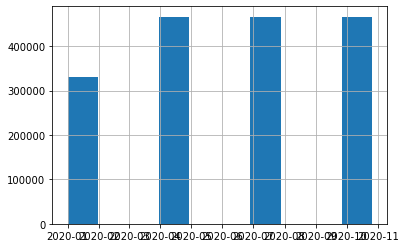

In [10]:
test_df.datetime.hist()

In [11]:
df.groupby('target').count()

,datetime,road_id,road_km
target,,,
1,89112,89112,89112
2,23166,23166,23166
3,39,39,39


In [12]:
test_df.groupby('road_id').count()

,datetime,road_km,target
road_id,,,
9,763800,763800,0
14,965651,965651,0


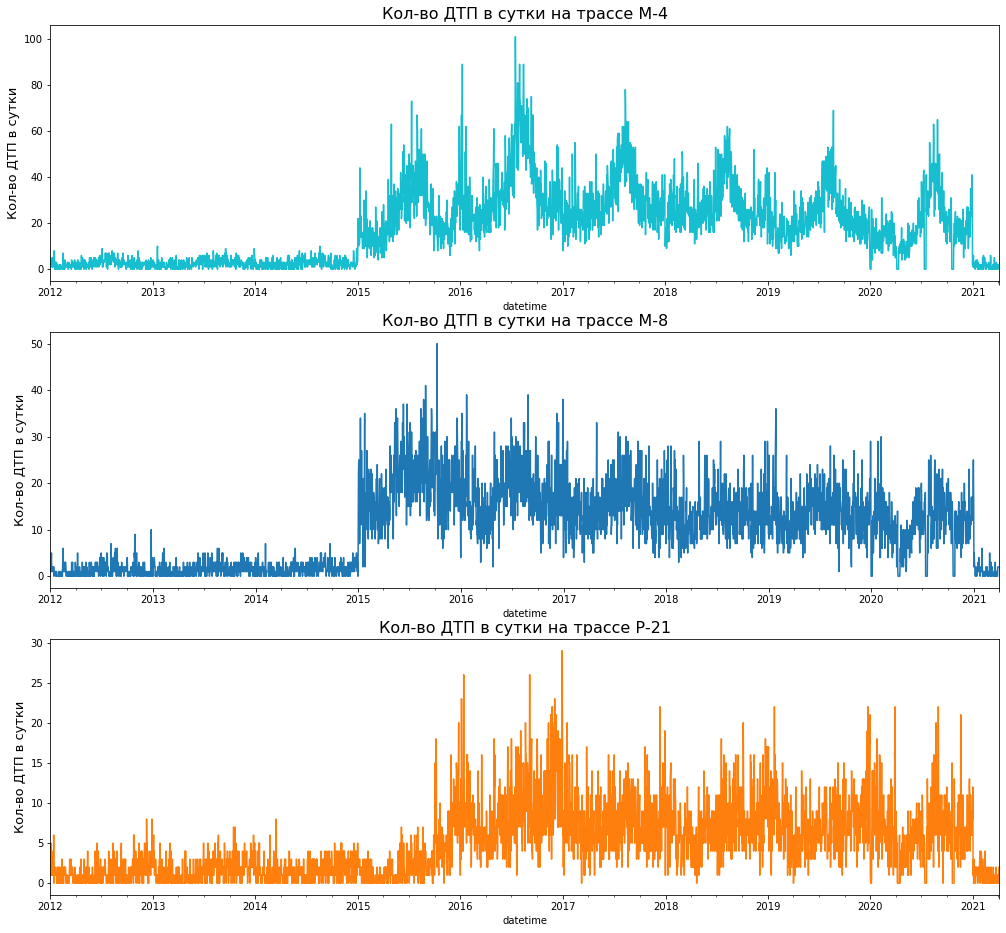

In [13]:
# распределение ДТП в расрезе трех трасс
fig, ax = plt.subplots(figsize=(17,16), ncols=1, nrows=3)

road_5 = df[df["road_id"]==5]
road_9 = df[df["road_id"]==9]
road_14 = df[df["road_id"]==14]

dtp_day_5 = road_5[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_9 = road_9[['datetime', 'target']].set_index('datetime').resample('D').count()['target']
dtp_day_14 = road_14[['datetime', 'target']].set_index('datetime').resample('D').count()['target']

dtp_day_5.plot(color='tab:cyan', ax=ax[0]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_9.plot(color='tab:blue', ax=ax[1]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)
dtp_day_14.plot(color='tab:orange', ax=ax[2]).set_ylabel('Кол-во ДТП в сутки', fontsize=13)

ax[0].set_title('Кол-во ДТП в сутки на трассе М-4',loc='center', fontsize=16)
ax[1].set_title('Кол-во ДТП в сутки на трассе М-8',loc='center', fontsize=16)
ax[2].set_title('Кол-во ДТП в сутки на трассе Р-21',loc='center', fontsize=16)
plt.show()

На временном интервале от 2012-01-01 до 2021-04-05 можно наблюдать разброс в количестве аварий по дням в разрезе лет: так, с 2016 года суточный показатель ДТП значительно больше по каждой из рассматриваемых трасс. Такой разброс объясняетсся различной представленностью данных МЧС (15059) и ГИБДД (94678 наблюдений) с отсутствием последних на интервале 2012-2015 гг. (см. график ниже). 

Для дальнейшего обучения модели **выберем данные о ДТП по трассе М-8**. Рассмотрим ситуацию для значений переменной `target` 1 и 2, исключив ЧС. Выберем период наблюдения с 2019-01-01 по 2020-12-31, заполним промежутки между наблюдениями на всем временном интервале нулевыми значениями с шагом в один час, присвоив значения 0 (событие не является ДТП) переменной `target`, и обогатим исходную выборку переменными из других датасетов.

In [14]:
road_5.head()

,datetime,road_id,road_km,target
2,2012-01-01 23:00:00,5,72,2
3,2012-01-02 07:00:00,5,1177,2
4,2012-01-02 08:00:00,5,1344,2
5,2012-01-02 17:00:00,5,875,2
8,2012-01-02 20:00:00,5,201,2


In [15]:
road_9_14 = df[df["road_id"]!=5]
road_9_14.head(5)

,datetime,road_id,road_km,target
0,2012-01-01 12:00:00,14,1276,2
1,2012-01-01 22:00:00,9,278,2
6,2012-01-02 17:00:00,14,432,1
7,2012-01-02 18:00:00,14,1,1
9,2012-01-02 20:00:00,9,451,2


In [16]:
# исключение из выборки ЧС и определение временного интервала
condition1 = (road_9_14["target"]!=3)
condition2 = (road_9_14['datetime'] >= '2018-01-01')
condition3 = (road_9_14['datetime'] <= '2020-12-31')
road_9_14 = road_9_14[(condition1 & condition2 & condition3)]
road_9_14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21547 entries, 64984 to 111926
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  21547 non-null  datetime64[ns]
 1   road_id   21547 non-null  int64         
 2   road_km   21547 non-null  int64         
 3   target    21547 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 841.7 KB


In [17]:
road_9_14.head()

,datetime,road_id,road_km,target
64984,2018-01-01 01:00:00,9,730,1
64988,2018-01-01 04:00:00,9,57,1
64989,2018-01-01 05:00:00,9,689,2
64990,2018-01-01 07:00:00,14,52,2
64994,2018-01-01 15:00:00,9,511,1


## Обагащение выборки переменными из датасетов `traffic.csv`

Хотелось бы знать: количество полос, volume (интенсивность движения), occupancy (загрузка полосы), средняя скорость

In [18]:
traffic = pd.read_csv('traffic.csv', usecols=[0, 1, 2, 6, 7, 8, 9, 10, 11], parse_dates=['datetime'])

In [19]:
traffic.shape

(7343154, 9)

In [20]:
condition1 = (traffic["road_id"]!=5)
condition2 = (traffic['datetime'] > '2018-01-01')
condition3 = (traffic['datetime'] < '2020-12-31')
traffic = traffic[condition1 & condition2 & condition3]
#traffic = traffic[condition1]

Преобразуем данные так, чтобы в одной строчке была информция по трафику по всем полосам

In [21]:
traffic.direction = traffic.direction.map({'backward': 0, 'forward': 1})

In [22]:
traffic['new_lane'] = traffic['direction'].values * 6 + traffic['lane'].values
traffic['lane_count_f'] = traffic['direction'].values * traffic['lane_count'].values
traffic['lane_count_b'] = (1-traffic['direction'].values) * traffic['lane_count'].values
traffic = traffic.drop('lane_count', axis=1)

In [23]:
traffic.head()

,datetime,road_id,road_km,lane,direction,volume,occupancy,speed,new_lane,lane_count_f,lane_count_b
1211086,2018-01-01 00:59:59,9,473,2,0,110.0,3.64,78.9,2,0,2
1211087,2018-01-01 00:59:59,9,473,1,0,98.0,3.25,73.7,1,0,2
1211088,2018-01-01 00:59:59,9,1062,1,0,4.0,0.20,80.0,1,0,1
1211089,2018-01-01 00:59:59,9,1062,1,1,14.0,0.96,43.4,7,1,0
1211090,2018-01-01 00:59:59,9,1062,1,0,4.0,0.20,80.0,1,0,1


In [24]:
traffic = pd.get_dummies(traffic, prefix=['volume'], columns=['new_lane'])

In [25]:
traffic.loc[:, [f"occupancy_{i}" for i in range(1, 13)]] = traffic.loc[:, [f"volume_{i}" for i in range(1, 13)]].values * traffic.occupancy.values.reshape(-1, 1)
traffic.loc[:, [f"speed_{i}" for i in range(1, 13)]] = traffic.loc[:, [f"volume_{i}" for i in range(1, 13)]].values * traffic.speed.values.reshape(-1, 1)
traffic.loc[:, [f"volume_{i}" for i in range(1, 13)]] = traffic.loc[:, [f"volume_{i}" for i in range(1, 13)]].values * traffic.volume.values.reshape(-1, 1)

In [26]:
agg_dict = {}

for word in ['volume', 'occupancy', 'speed']:
    for i in range(1, 13):
        agg_dict[word+'_'+str(i)] =  'sum'
        
agg_dict['lane_count_f'] = 'max'
agg_dict['lane_count_b'] = 'max'

In [27]:
tr_traffic = traffic.groupby(['datetime', 'road_id', 'road_km']).agg(agg_dict)

In [28]:
tr_traffic.head()

volume_1  volume_2  volume_3  volume_4  \
datetime            road_id road_km                                           
2018-01-01 00:59:59 9       181          74.0       0.0       0.0       0.0   
                            231         100.0       4.0       0.0       0.0   
                            274         128.0      48.0       0.0       0.0   
                            279           0.0       0.0       0.0       0.0   
                            327          28.0       0.0       0.0       0.0   

                                     volume_5  volume_6  volume_7  volume_8  \
datetime            road_id road_km                                           
2018-01-01 00:59:59 9       181           0.0       0.0      90.0       0.0   
                            231           0.0       0.0      70.0      30.0   
                            274           0.0       0.0     144.0      56.0   
                            279           0.0       0.0      56.0       0.0   
                            327           0.0       0.0       2.0      44.0   

                                     volume_9  volume_10  volume_11  \
datetime            road_id road_km                                   
2018-01-01 00:59:59 9       181           0.0        0.0        0.0   
                            231           0.0        0.0        0.0   
                            274           0.0        0.0        0.0   
                            279           0.0        0.0        0.0   
                            327           0.0        0.0        0.0   

                                     volume_12  occupancy_1  occupancy_2  \
datetime            road_id road_km                                        
2018-01-01 00:59:59 9       181            0.0          2.0         0.00   
                            231            0.0          2.0         2.00   
                            274            0.0          8.4         3.14   
                            279            0.0          0.0         0.00   
                            327            0.0          2.1         0.00   

                                     occupancy_3  occupancy_4  occupancy_5  \
datetime            road_id road_km                                          
2018-01-01 00:59:59 9       181              0.0          0.0          0.0   
                            231              0.0          0.0          0.0   
                            274              0.0          0.0          0.0   
                            279              0.0          0.0          0.0   
                            327              0.0          0.0          0.0   

                                     occupancy_6  occupancy_7  occupancy_8  \
datetime            road_id road_km                                          
2018-01-01 00:59:59 9       181              0.0         2.00         0.00   
                            231              0.0         2.00         2.00   
                            274              0.0         9.96         3.68   
                            279              0.0         4.20         0.00   
                            327              0.0        16.00         3.30   

                                     occupancy_9  occupancy_10  occupancy_11  \
datetime            road_id road_km                                            
2018-01-01 00:59:59 9       181              0.0           0.0           0.0   
                            231              0.0           0.0           0.0   
                            274              0.0           0.0           0.0   
                            279              0.0           0.0           0.0   
                            327              0.0           0.0           0.0   

                                     occupancy_12  speed_1  speed_2  speed_3  \
datetime            road_id road_km                                            
2018-01-01 00:59:59 9       181               0.0   137.34      0.0      0.0   
   

In [29]:
tr_traffic = tr_traffic.replace({0:np.nan}).reset_index()

In [30]:
tr_traffic.head()

,datetime,road_id,road_km,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b
0,2018-01-01 00:59:59,9,181,74.0,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,137.34,NaN,NaN,NaN,NaN,NaN,116.84,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,2018-01-01 00:59:59,9,231,100.0,4.0,NaN,NaN,NaN,NaN,70.0,30.0,NaN,NaN,NaN,NaN,2.0,2.00,NaN,NaN,NaN,NaN,2.00,2.00,NaN,NaN,NaN,NaN,190.66,1.0,NaN,NaN,NaN,NaN,136.54,17.0,NaN,NaN,NaN,NaN,2.0,2.0
2,2018-01-01 00:59:59,9,274,128.0,48.0,NaN,NaN,NaN,NaN,144.0,56.0,NaN,NaN,NaN,NaN,8.4,3.14,NaN,NaN,NaN,NaN,9.96,3.68,NaN,NaN,NaN,NaN,160.00,180.0,NaN,NaN,NaN,NaN,174.40,184.0,NaN,NaN,NaN,NaN,2.0,2.0
3,2018-01-01 00:59:59,9,279,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184.00,NaN,NaN,NaN,NaN,NaN,2.0,2.0
4,2018-01-01 00:59:59,9,327,28.0,NaN,NaN,NaN,NaN,NaN,2.0,44.0,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,16.00,3.30,NaN,NaN,NaN,NaN,158.00,NaN,NaN,NaN,NaN,NaN,78.00,166.0,NaN,NaN,NaN,NaN,2.0,2.0


In [31]:
#Добавим среднее и дисперсию трафика вдоль каждого направления
for word in ['volume', 'occupancy', 'speed']:
    tr_traffic['mean_'+word+'_b'] = np.nanmean(tr_traffic.loc[:, [f"{word}_{i}" for i in range(1, 7)]].values, axis=1)
    tr_traffic['mean_'+word+'_f'] = np.nanmean(tr_traffic.loc[:, [f"{word}_{i}" for i in range(7, 13)]].values, axis=1)
    tr_traffic['std_'+word+'_b'] = np.nanstd(tr_traffic.loc[:, [f"{word}_{i}" for i in range(1, 7)]].values, axis=1)
    tr_traffic['std_'+word+'_f'] = np.nanstd(tr_traffic.loc[:, [f"{word}_{i}" for i in range(7, 13)]].values, axis=1)
          

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programs\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [32]:
tr_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317826 entries, 0 to 1317825
Data columns (total 53 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1317826 non-null  datetime64[ns]
 1   road_id           1317826 non-null  int64         
 2   road_km           1317826 non-null  int64         
 3   volume_1          1238626 non-null  float64       
 4   volume_2          471775 non-null   float64       
 5   volume_3          70598 non-null    float64       
 6   volume_4          2657 non-null     float64       
 7   volume_5          2656 non-null     float64       
 8   volume_6          2657 non-null     float64       
 9   volume_7          1270140 non-null  float64       
 10  volume_8          411443 non-null   float64       
 11  volume_9          95111 non-null    float64       
 12  volume_10         2657 non-null     float64       
 13  volume_11         2656 non-null     float6

In [33]:
def hour_rounder(t):
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [34]:
# округление переменной datetime до часа
tr_traffic['datetime'] = tr_traffic['datetime'].map(lambda x: hour_rounder(x))

In [35]:
# объединение датасета с данными о ДТП с данными о трафике
tmp = pd.merge(road_9_14, tr_traffic, how='outer', on=['datetime', 'road_km', 'road_id'])
condition1 = (tmp['target'].isnull()) & (tmp['lane_count_f'].isnull()) & (tmp['lane_count_b'].isnull())
#condition2 = (tmp['lane_count'].isnull())
tmp = tmp.drop(tmp[condition1].index)
#tmp = tmp.drop(tmp[condition2].index)
tmp.target = tmp.target.fillna(0)
tmp.head(5)

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
tmp[tmp['target']!=0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21547 entries, 0 to 21546
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          21547 non-null  datetime64[ns]
 1   road_id           21547 non-null  int64         
 2   road_km           21547 non-null  int64         
 3   target            21547 non-null  float64       
 4   volume_1          685 non-null    float64       
 5   volume_2          381 non-null    float64       
 6   volume_3          180 non-null    float64       
 7   volume_4          26 non-null     float64       
 8   volume_5          26 non-null     float64       
 9   volume_6          26 non-null     float64       
 10  volume_7          715 non-null    float64       
 11  volume_8          388 non-null    float64       
 12  volume_9          219 non-null    float64       
 13  volume_10         26 non-null     float64       
 14  volume_11         26 n

In [37]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338634 entries, 0 to 1338633
Data columns (total 54 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1338634 non-null  datetime64[ns]
 1   road_id           1338634 non-null  int64         
 2   road_km           1338634 non-null  int64         
 3   target            1338634 non-null  float64       
 4   volume_1          1238626 non-null  float64       
 5   volume_2          471775 non-null   float64       
 6   volume_3          70598 non-null    float64       
 7   volume_4          2657 non-null     float64       
 8   volume_5          2656 non-null     float64       
 9   volume_6          2657 non-null     float64       
 10  volume_7          1270140 non-null  float64       
 11  volume_8          411443 non-null   float64       
 12  volume_9          95111 non-null    float64       
 13  volume_10         2657 non-null     float6

array([<AxesSubplot:title={'center':'1.0'}>,
       <AxesSubplot:title={'center':'2.0'}>], dtype=object)

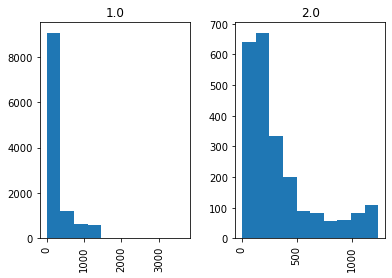

In [38]:
road9 = tmp[tmp.road_id==9]
road9[road9.target != 0].hist('road_km', by='target')

## Обагащение выборки переменными из датасетов `repair.csv`

In [39]:
repair = pd.read_csv('repair.csv', parse_dates=['datetime'])
# фильтр датасетов traffic.csv, repair.csv по заданным уловиям
condition1 = (repair["road_id"]!=5)
condition2 = (repair['datetime'] >= '2017-01-01') & (repair['datetime'] <= '2020-01-01')
repair = repair[condition1 & condition2]

In [40]:
repair.head()

,datetime,road_id,road_km,repair_id,repair_description,repair_period,length,price
8,2017-01-01,9,691,35,"Водопропускная труба на км 691+945 автомобильной дороги М-8 ""Холмогоры"" Москва - Ярославль - Вологда – Архангельск",2017,39.00,18896.868
9,2017-01-01,9,1100,74,"Капитальный ремонт моста через реку Смердья на км 1100+802 автомобильной дороги М-8 ""Холмогоры"" Москва - Ярославль - Вологда – Архангельск в Архангельской области",2017 - 2018,0.00,103429.000
10,2017-01-01,9,125,93,"Мост через лог на км 125+655 автомобильной дороги М-8 ""Холмогоры"" Москва - Ярославль - Вологда - Архангельск",2016 - 2017,2.75,24631.530
11,2017-01-01,9,166,119,"Мост через суходол на км 166+120 автомобильной дороги М-8 ""Холмогоры"" Москва - Вологда - Ярославль - Архангельск",2016 - 2017,3.80,10534.930
12,2017-01-01,9,191,105,"Мост через реку Сара на км 191+500 автомобильной дороги М-8 ""Холмогоры"" Москва - Ярославль - Вологда - Архангельск",2017 - 2018,0.00,75009.351


In [41]:
# добавление данных о ремонте дороги на указанном километре
tmp['year'] = tmp['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)
index_repair = tmp[tmp.set_index(['road_km','year', 'road_id']).index.isin(repair.set_index(['road_km','year', 'road_id']).index)].index
tmp.loc[index_repair, 'repair'] = 1
tmp.repair = tmp.repair.fillna(0)
tmp.head()

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0


## Обагащение выборки переменными из датасета `crash_parts.csv`

Хорошо бы знать: является ли участок аварийным, тип участка

In [42]:
crashes = pd.read_csv('crash_parts.csv', usecols=[1, 2, 3, 7, 8], parse_dates=['datetime'])
crashes.head()

,datetime,road_id,road_km,avuch_loc,stabchar_type
0,2017-01-01,9,124,2,3
1,2017-01-01,9,125,2,3
2,2017-01-01,9,131,2,3
3,2017-01-01,9,132,2,3
4,2017-01-01,9,145,2,1


In [43]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       167 non-null    datetime64[ns]
 1   road_id        167 non-null    int64         
 2   road_km        167 non-null    int64         
 3   avuch_loc      167 non-null    int64         
 4   stabchar_type  167 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 6.6 KB


In [44]:
#Возьмем информацию об участках с 2018 года
condition = ((crashes['datetime'] >= '2018-01-01') & (crashes['datetime'] <= '2020-01-01'))
crashes[condition].shape

(97, 5)

In [45]:
#crashes['year'] = repair['datetime'].map(lambda x: x.year)

tmp = pd.merge(tmp, crashes.drop('datetime', axis=1), on=['road_id', 'road_km'], how="left")

In [46]:
tmp.head()

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair,avuch_loc,stabchar_type
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN


In [47]:
tmp[tmp.target!=0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25307 entries, 0 to 25306
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          25307 non-null  datetime64[ns]
 1   road_id           25307 non-null  int64         
 2   road_km           25307 non-null  int64         
 3   target            25307 non-null  float64       
 4   volume_1          875 non-null    float64       
 5   volume_2          443 non-null    float64       
 6   volume_3          242 non-null    float64       
 7   volume_4          26 non-null     float64       
 8   volume_5          26 non-null     float64       
 9   volume_6          26 non-null     float64       
 10  volume_7          896 non-null    float64       
 11  volume_8          450 non-null    float64       
 12  volume_9          281 non-null    float64       
 13  volume_10         26 non-null     float64       
 14  volume_11         26 n

## Обагащение выборки переменными из датасета `tele2_data.csv`

Хорошо бы знать: количество населения, передвигавшегося по сегменту дороги

In [48]:
tele2 = pd.read_csv('tele2_data.csv', parse_dates=['datetime'])
tele2.head()

,datetime,road_id,road_km,cnt_subs
0,2020-12-01 00:00:00,9,0,85
1,2020-12-01 01:00:00,9,0,81
2,2020-12-01 02:00:00,9,0,69
3,2020-12-01 03:00:00,9,0,55
4,2020-12-01 04:00:00,9,0,69


In [49]:
tmp = pd.merge(tmp, tele2, on=['datetime', 'road_id', 'road_km'], how="left")

In [50]:
tmp.head()

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair,avuch_loc,stabchar_type,cnt_subs
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN


In [51]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395116 entries, 0 to 1395115
Data columns (total 59 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   datetime          1395116 non-null  datetime64[ns]
 1   road_id           1395116 non-null  int64         
 2   road_km           1395116 non-null  int64         
 3   target            1395116 non-null  float64       
 4   volume_1          1289574 non-null  float64       
 5   volume_2          502192 non-null   float64       
 6   volume_3          100977 non-null   float64       
 7   volume_4          2658 non-null     float64       
 8   volume_5          2656 non-null     float64       
 9   volume_6          2657 non-null     float64       
 10  volume_7          1318262 non-null  float64       
 11  volume_8          441856 non-null   float64       
 12  volume_9          125456 non-null   float64       
 13  volume_10         2658 non-null     float6

## Добавляем информацию о ближайшей станции для обагащения выборки переменными из датасетов `atmos.csv` и `meteo.csv`

In [52]:
#информацию о погоде со станций
atmos = pd.read_csv('atmos.csv', parse_dates=['start_date', 'end_date'])
atmos.head(2)

,Unnamed: 0,road_id,station,lat,lon,phenomenon,phenomenon_q,intensity,intensity_q,start_date,start_ts,start_q,end_date,end_ts,end_q
0,0,9,ALEKSAN,56.4,38.75,снег,Значение элемента достоверно,слабая интенсивность,Значение элемента достоверно,2015-01-01,7:00,Значение элемента достоверно,2015-01-01,8:30,Значение элемента достоверно
1,1,9,ALEKSAN,56.4,38.75,снег,Значение элемента достоверно,умеренная интенсивность,Значение элемента достоверно,2015-01-01,9:00,Значение элемента достоверно,2015-01-01,10:20,Значение элемента достоверно


Нужно перевести километр трассы и номер трассы в координаты, потом перевести координаты в ближаюшую станцию

In [53]:
#еще одна инфа о погоде
meteo = pd.read_csv("meteo.csv")

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
meteo.head(2)

,Unnamed: 0,road_id,station,lat,lon,measure_dt,vsp_1,vsp_1_q,vsp_2,vsp_2_q,vsp_3,vsp_3_q,visib,visib_q,clouds,clouds_q,weather_range,weather_range_q,weather_on_measure,weather_on_measure_q,wind_dir,wind_dir_q,avg_wind,avg_wind_q,max_wind,max_wind_q,precip,precip_q,temp_on_measure,temp_on_measure_q,temp_min,temp_min_q,temp_max,temp_max_q,humidity,humidity_q,pressure,pressure_q
0,0,9,ALEKSAN,56.4,38.75,2015-01-01 18:00:00,16.0,Значение элемента достоверно,16.0,Значение элемента достоверно,16.0,Значение элемента достоверно,97.0,Значение элемента достоверно,6.0,Значение элемента достоверно,Пасмурно или облачность более 5 баллов,Значение элемента достоверно,Облака рассеиваются,Значение элемента достоверно,229.0,Значение элемента достоверно,2.0,Значение элемента достоверно,5.0,Значение элемента достоверно,NaN,Значение элемента отсутствует,-8.4,Значение элемента достоверно,-9.7,Значение элемента достоверно,-8.4,Значение элемента достоверно,95.0,Значение элемента достоверно,986.2,Значение элемента достоверно
1,1,9,ALEKSAN,56.4,38.75,2015-01-01 21:00:00,16.0,Значение элемента достоверно,16.0,Значение элемента достоверно,16.0,Значение элемента достоверно,97.0,Значение элемента достоверно,6.0,Значение элемента достоверно,Пасмурно или облачность более 5 баллов,Значение элемента достоверно,Небо без изменений,Значение элемента достоверно,220.0,Значение элемента достоверно,2.0,Значение элемента достоверно,5.0,Значение элемента достоверно,NaN,Значение элемента отсутствует,-6.8,Значение элемента достоверно,-8.4,Значение элемента достоверно,-6.4,Значение элемента достоверно,92.0,Значение элемента достоверно,985.0,Значение элемента достоверно


In [55]:
#координаты километров трассы
geo_data = pd.read_csv('geo_data.csv', usecols=[0, 1, 3, 4, 5])
geo_data.head()

,road_id,road_km,lat_geoc,lon_geoc,lat_glonass
0,9,0,55.755975,37.613846,56.218809
1,9,1,55.758915,37.620349,56.554579
2,9,2,55.761990,37.633704,56.546578
3,9,3,55.768684,37.641095,NaN
4,9,4,55.768529,37.631879,NaN


In [56]:
def coord_km(dataframe):
    dataframe=dataframe.rename(columns={'lat_geoc': "Широта"})
    dataframe=dataframe.rename(columns={'lon_geoc': "Долгота"})
    dataframe['Широта']=round(dataframe['Широта'], 2)
    dataframe['Долгота']=round(dataframe['Долгота'], 2)
    dataframe['lat_long'] = dataframe[['Широта', 'Долгота']].apply(tuple, axis=1)
    return dataframe

In [64]:
#возьмем координаты lon_geoc так как для них есть все данные
km_coord = coord_km(geo_data)[['road_id', 'road_km', 'lat_long']]

In [65]:
km_coord.head()

,road_id,road_km,lat_long
0,9,0,"(55.76, 37.61)"
1,9,1,"(55.76, 37.62)"
2,9,2,"(55.76, 37.63)"
3,9,3,"(55.77, 37.64)"
4,9,4,"(55.77, 37.63)"


In [66]:
# Теперь создаем полный список метеостанций для обеих трасс
seed = 43

meteo_sam=meteo.groupby("station").sample(frac=0.001, random_state=seed)
meteo_sam.loc[meteo_sam['station']=='MOSKBAL', 'lat'] = 55.8 # вручную добавляем координаты для станций 'MOSKBAL' и 'MONCHEG', взятые из других датасетов Росгидромета
meteo_sam.loc[meteo_sam['station']=='MOSKBAL', 'lon'] = 37.5
meteo_sam.loc[meteo_sam['station']=='MONCHEG', 'lat'] = 67.9 
meteo_sam.loc[meteo_sam['station']=='MONCHEG', 'lon'] = 32.9


In [67]:
# функция, склеивающая колонки с координатами в кортеж 
def coord_merg(dataframe):
    dataframe['lat_long']=dataframe[['lat', 'lon']].apply(tuple, axis=1)
    return dataframe 

def stations_list(dataframe):
    dataframe=dataframe[['station','lat_long']]
    dataframe=dataframe.drop_duplicates()
    dataframe=dataframe.set_axis(range(0,len(dataframe)))
    return dataframe

In [68]:
# немного преобразуем данные и создаем список всех станций
coord_merg(meteo_sam)
full_stations_list=stations_list(meteo_sam)
full_stations_list.head()

,station,lat_long
0,ALEKSAN,"(56.4, 38.75)"
1,APATIT,"(67.55, 33.35)"
2,ARHAN01,"(64.6166638888889, 40.516663888888885)"
3,BABAEVO,"(59.4, 35.93)"
4,BIRYKOV,"(59.58, 41.48)"


In [62]:
#теперь загружаем  датасет, к которо для каждого километра дороги найдена ближайшая станция
#если такого датасета нет, то выполняем ячейку ниже
km_coord = pd.read_csv('km_to_station.csv')
km_coord.head()

,road_id,road_km,lat_long,station
0,9,0,"(55.76, 37.61)",NaN
1,9,1,"(55.76, 37.62)",NaN
2,9,2,"(55.76, 37.63)",NaN
3,9,3,"(55.77, 37.64)",NaN
4,9,4,"(55.77, 37.63)",NaN


In [69]:
#Для каждого километра дороги находим его ближайшую станцию (считается пару минут)
#(можно не выполнять, если загрузили датасет km_to_station.csv выше)


def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point) == True:
        lst.append(np.nan)
    elif pd.isnull(point[0]) == True:
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
            y=stations_list['station'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("[0-9]", "", y)
        y=re.sub(" ", "", y)
        return y

km_coord['station'] = km_coord['lat_long'].map(functools.partial(stat_km, stat_list=full_stations_list))
km_coord['station'] = km_coord['station'].where(pd.notnull(km_coord['station']), np.nan) # т.к. функиця возвращает None для пропусков, вручную меняем на NaN
km_coord.head()

,road_id,road_km,lat_long,station
0,9,0,"(55.76, 37.61)",MOSKMIH
1,9,1,"(55.76, 37.62)",MOSKMIH
2,9,2,"(55.76, 37.63)",MOSKMIH
3,9,3,"(55.77, 37.64)",MOSKMIH
4,9,4,"(55.77, 37.63)",MOSKMIH


In [70]:
km_coord.shape

(2810, 4)

In [71]:
km_coord = km_coord.drop_duplicates(subset=['road_id', 'road_km'])

In [72]:
#сохраняем датасет при необходимости
km_coord.to_csv('km_to_station.csv', index=False)

In [73]:
#добавляем название станции в тренировочный датасет
tmp_station=pd.merge(tmp, km_coord, on=["road_id", "road_km"], how='left')

In [74]:
tmp_station.head(2)

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair,avuch_loc,stabchar_type,cnt_subs,lat_long,station
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(61.13, 42.12)",VELSK
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(56.18, 38.03)",MOSKVDN


### Обагащение выборки переменными из датасета `atmos.csv`

In [75]:
condition1 = (atmos['end_date'] >= '2018-01-01')
condition2 = (atmos['start_date'] <= '2020-12-31')
atmos = atmos[(condition1 & condition2)]

In [76]:
atmos.head(2)

,Unnamed: 0,road_id,station,lat,lon,phenomenon,phenomenon_q,intensity,intensity_q,start_date,start_ts,start_q,end_date,end_ts,end_q
7539,7539,9,ALEKSAN,56.4,38.75,снег ливневый мокрый,Значение элемента достоверно,сильная интенсивность,Значение элемента достоверно,2017-12-31,23:35,Значение элемента достоверно,2018-01-01,0:00,Значение элемента достоверно
7553,7553,9,ALEKSAN,56.4,38.75,снег,Значение элемента достоверно,слабая интенсивность,Значение элемента достоверно,2018-01-01,15:00,Значение элемента достоверно,2018-01-01,15:20,Значение элемента достоверно


Нам интересны: phenomenon, intensity

In [77]:
atmos = atmos[['road_id', 'station', 'phenomenon', 'intensity', 'start_date', 'start_ts', 'end_date', 'end_ts']]
atmos.head(5)

,road_id,station,phenomenon,intensity,start_date,start_ts,end_date,end_ts
7539,9,ALEKSAN,снег ливневый мокрый,сильная интенсивность,2017-12-31,23:35,2018-01-01,0:00
7553,9,ALEKSAN,снег,слабая интенсивность,2018-01-01,15:00,2018-01-01,15:20
7554,9,ALEKSAN,дымка,слабая интенсивность,2018-01-01,15:00,2018-01-01,15:06
7555,9,ALEKSAN,дымка,умеренная интенсивность,2018-01-01,15:06,2018-01-01,16:37
7556,9,ALEKSAN,дымка,слабая интенсивность,2018-01-01,16:37,2018-01-01,17:00


In [78]:
atmos[['start_ts', 'end_ts']] = atmos[['start_ts', 'end_ts']].fillna('0:00')

In [79]:
atmos['start_ts'] = pd.to_datetime(atmos['start_ts'], format= '%H:%M').dt.time
atmos['end_ts'] = pd.to_datetime(atmos['end_ts'], format= '%H:%M').dt.time

In [80]:
atmos['start_datetime'] = atmos.apply(lambda r : pd.datetime.combine(r['start_date'], r['start_ts']),1)
atmos['end_datetime'] = atmos.apply(lambda r : pd.datetime.combine(r['end_date'], r['end_ts']),1)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [81]:
atmos = atmos.drop(['start_ts', 'end_ts'], axis=1)
atmos.head(2)

,road_id,station,phenomenon,intensity,start_date,end_date,start_datetime,end_datetime
7539,9,ALEKSAN,снег ливневый мокрый,сильная интенсивность,2017-12-31,2018-01-01,2017-12-31 23:35:00,2018-01-01 00:00:00
7553,9,ALEKSAN,снег,слабая интенсивность,2018-01-01,2018-01-01,2018-01-01 15:00:00,2018-01-01 15:20:00


In [82]:
(atmos.end_date - atmos.start_date).value_counts()

0 days    250941
1 days     21971
dtype: int64

Смотрим на максимальную длительность феномена, она равна одному дню. Напишем для каждого являния, в какие дни он идет конкретно

In [83]:
atmos_1 = atmos.drop('end_date', axis=1)
atmos_1 = atmos_1.rename(columns={'start_date': 'date'})

In [84]:
atmos_2 = atmos.drop('start_date', axis=1)
atmos_2 = atmos_2.rename(columns={'end_date': 'date'})

In [85]:
atmos = pd.concat([atmos_1, atmos_2], ignore_index=True)

In [86]:
atmos.shape

(545824, 7)

In [87]:
atmos = atmos.drop_duplicates(ignore_index=True)

In [88]:
atmos.head()

,road_id,station,phenomenon,intensity,date,start_datetime,end_datetime
0,9,ALEKSAN,снег ливневый мокрый,сильная интенсивность,2017-12-31,2017-12-31 23:35:00,2018-01-01 00:00:00
1,9,ALEKSAN,снег,слабая интенсивность,2018-01-01,2018-01-01 15:00:00,2018-01-01 15:20:00
2,9,ALEKSAN,дымка,слабая интенсивность,2018-01-01,2018-01-01 15:00:00,2018-01-01 15:06:00
3,9,ALEKSAN,дымка,умеренная интенсивность,2018-01-01,2018-01-01 15:06:00,2018-01-01 16:37:00
4,9,ALEKSAN,дымка,слабая интенсивность,2018-01-01,2018-01-01 16:37:00,2018-01-01 17:00:00


Cоединяем наши датасеты

In [89]:
tmp_station['date'] = tmp_station['datetime'].map(lambda x: x.date())
tmp_station['date'] = pd.to_datetime(tmp_station['date'], format='%Y-%m-%d')

tmp_station_w=pd.merge(tmp_station, atmos, on=["road_id", "station", 'date'],how='left')

condition1 = (tmp_station_w['datetime'] < tmp_station_w['start_datetime'])
condition2 = (tmp_station_w['datetime'] > tmp_station_w['end_datetime'])


tmp_station_w = tmp_station_w.drop(tmp_station_w[condition1 | condition2].index)

In [90]:
tmp_station=pd.merge(tmp_station, tmp_station_w, on=list(tmp_station.columns), how='left')

In [91]:
tmp_station.head()

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair,avuch_loc,stabchar_type,cnt_subs,lat_long,station,date,phenomenon,intensity,start_datetime,end_datetime
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(61.13, 42.12)",VELSK,2018-01-01,снег мокрый,слабая интенсивность,2018-01-01 00:00:00,2018-01-01 01:23:00
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(56.18, 38.03)",MOSKVDN,2018-01-01,дымка,слабая интенсивность,2018-01-01 03:00:00,2018-01-01 05:30:00
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN,"(60.79, 42.03)",VELSK,2018-01-01,NaN,NaN,NaT,NaT
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(59.89, 31.19)",SHLISSE,2018-01-01,NaN,NaN,NaT,NaT
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN,"(59.52, 40.39)",VOLOGDA,2018-01-01,снег,слабая интенсивность,2018-01-01 15:00:00,2018-01-01 15:50:00


### Добавляем дни недели и час

In [108]:
tmp_station['hour'] = tmp_station['datetime'].apply(lambda x: x.hour)
tmp_station['weekday'] = tmp_station['datetime'].apply(lambda x: x.weekday())

In [109]:
tmp_station.shape

(1683767, 68)

### Добавляем время года

In [118]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))

tmp_station['year_season'] = tmp_station.datetime.dt.month.map(month_to_season)

In [119]:
tmp_station.head()

,datetime,road_id,road_km,target,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,occupancy_1,occupancy_2,occupancy_3,occupancy_4,occupancy_5,occupancy_6,occupancy_7,occupancy_8,occupancy_9,occupancy_10,occupancy_11,occupancy_12,speed_1,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7,speed_8,speed_9,speed_10,speed_11,speed_12,lane_count_f,lane_count_b,mean_volume_b,mean_volume_f,std_volume_b,std_volume_f,mean_occupancy_b,mean_occupancy_f,std_occupancy_b,std_occupancy_f,mean_speed_b,mean_speed_f,std_speed_b,std_speed_f,year,repair,avuch_loc,stabchar_type,cnt_subs,lat_long,station,date,phenomenon,intensity,start_datetime,end_datetime,hour,weekday,year_season
0,2018-01-01 01:00:00,9,730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(61.13, 42.12)",VELSK,2018-01-01,снег мокрый,слабая интенсивность,2018-01-01 00:00:00,2018-01-01 01:23:00,1,0,1
1,2018-01-01 04:00:00,9,57,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(56.18, 38.03)",MOSKVDN,2018-01-01,дымка,слабая интенсивность,2018-01-01 03:00:00,2018-01-01 05:30:00,4,0,1
2,2018-01-01 05:00:00,9,689,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN,"(60.79, 42.03)",VELSK,2018-01-01,NaN,NaN,NaT,NaT,5,0,1
3,2018-01-01 07:00:00,14,52,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,0.0,NaN,NaN,NaN,"(59.89, 31.19)",SHLISSE,2018-01-01,NaN,NaN,NaT,NaT,7,0,1
4,2018-01-01 15:00:00,9,511,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1.0,NaN,NaN,NaN,"(59.52, 40.39)",VOLOGDA,2018-01-01,снег,слабая интенсивность,2018-01-01 15:00:00,2018-01-01 15:50:00,15,0,1


In [94]:
tmp_station.loc[:100000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100001 entries, 0 to 100000
Data columns (total 66 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          100001 non-null  datetime64[ns]
 1   road_id           100001 non-null  int64         
 2   road_km           100001 non-null  int64         
 3   target            100001 non-null  float64       
 4   volume_1          63773 non-null   float64       
 5   volume_2          22030 non-null   float64       
 6   volume_3          3338 non-null    float64       
 7   volume_4          33 non-null      float64       
 8   volume_5          33 non-null      float64       
 9   volume_6          33 non-null      float64       
 10  volume_7          64745 non-null   float64       
 11  volume_8          18840 non-null   float64       
 12  volume_9          4302 non-null    float64       
 13  volume_10         33 non-null      float64       
 14  volu

In [120]:
tmp_station.to_csv('train_data_updated_v6.csv', index=False)

# Подготовка тестовой выборки

In [96]:
# загрузка выборки
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.shape

(1729451, 4)

##### Обагащение выборки переменными из датасетов `traffic.csv`

In [97]:
test = pd.merge(test, tr_traffic, how='left', on=['datetime', 'road_km', 'road_id'])
test.shape

(1729451, 54)

##### Обагащение выборки переменными из датасетов `repair.csv`

In [98]:
test['year'] = test['datetime'].map(lambda x: x.year)
repair['year'] = repair['datetime'].map(lambda x: x.year)
index_repair = test[test.set_index(['road_km','year', 'road_id']).index.isin(repair.set_index(['road_km','year', 'road_id']).index)].index
test.loc[index_repair, 'repair'] = 1
test.repair = test.repair.fillna(0)
test.shape

(1729451, 56)

##### Обагащение выборки переменными из датасетов `crash_parts.csv`

In [99]:
test = pd.merge(test, crashes.drop('datetime', axis=1), on=['road_id', 'road_km'], how="left")
test = test.drop_duplicates(subset=['datetime', 'road_id', 'road_km'])
test.shape

(1729451, 58)

##### Обагащение выборки переменными из датасета `tele2_data.csv`

In [100]:
test = pd.merge(test, tele2, on=['datetime', 'road_id', 'road_km'], how="left")
test.shape

(1729451, 59)

##### Обагащение выборки переменными из датасета 'atmos.csv'

In [101]:
#добавляем название станции в тренировочный датасет
test=pd.merge(test, km_coord, on=["road_id", "road_km"], how='left')
test.shape

(1729451, 61)

In [102]:
test['date'] = test['datetime'].map(lambda x: x.date())
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

test_w=pd.merge(test, atmos, on=['road_id', 'station', 'date'],how='left')

In [103]:
condition1 = (test_w['datetime'] < test_w['start_datetime'])
condition2 = (test_w['datetime'] > test_w['end_datetime'])


test_w = test_w.drop(test_w[condition1 | condition2].index)
test_w = test_w.drop_duplicates(subset=['datetime', 'road_id', 'road_km'])
test_w.shape

(1224052, 66)

In [104]:
test=pd.merge(test, test_w, on=list(test.columns), how='left')

##### Добавляем дни недели и час

In [112]:
test['hour'] = test['datetime'].apply(lambda x: x.hour)
test['weekday'] = test['datetime'].apply(lambda x: x.weekday())

##### Добавляем время года

In [121]:
test['year_season'] = test.datetime.dt.month.map(month_to_season)

In [105]:
print("Размер выборки для тестирования: ", test.shape)

Размер выборки для тестирования:  (1729451, 66)


In [122]:
test.to_csv('test_data_v6.csv', index=False)

In [107]:
test.iloc[:10000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 66 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          10000 non-null  datetime64[ns]
 1   road_id           10000 non-null  int64         
 2   road_km           10000 non-null  int64         
 3   target            0 non-null      float64       
 4   volume_1          131 non-null    float64       
 5   volume_2          43 non-null     float64       
 6   volume_3          4 non-null      float64       
 7   volume_4          0 non-null      float64       
 8   volume_5          0 non-null      float64       
 9   volume_6          0 non-null      float64       
 10  volume_7          134 non-null    float64       
 11  volume_8          36 non-null     float64       
 12  volume_9          8 non-null      float64       
 13  volume_10         0 non-null      float64       
 14  volume_11         0 non